In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
folder_path = '/content/drive/MyDrive/Brain Tumor prj'

In [5]:
train_folder = '/content/drive/MyDrive/Brain Tumor prj/Training'
test_folder = '/content/drive/MyDrive/Brain Tumor prj/Testing'

In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:
import os
files = os.listdir(folder_path)
print(files)

['Testing', 'Training']


In [8]:
def preprocess_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (224, 224))  # Resize to fit VGG16 input size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

In [9]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder
            for filename in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, filename)
                if os.path.isfile(file_path):
                    image = preprocess_image(file_path)
                    images.append(image)
                    labels.append(label)
    return np.array(images), np.array(labels)

In [10]:
X_train, y_train = load_images_from_folder(train_folder)
X_test, y_test = load_images_from_folder(test_folder)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

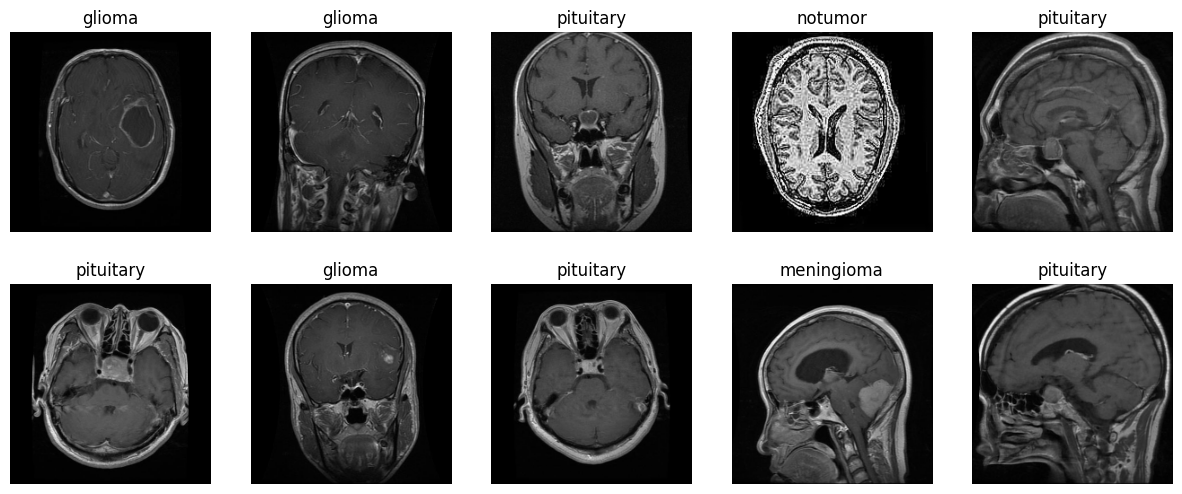

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.axis('off')
    ax.set_title(y_train[i])
plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [14]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(4, activation='softmax')  # Assuming 4 classes: glioma, meningioma, no tumor, pituitary
])

In [16]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [18]:
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_val, y_val_encoded))

Epoch 1/10
143/143 [==============================] - 20s 85ms/step - loss: 0.6986 - accuracy: 0.7148 - val_loss: 0.5047 - val_accuracy: 0.8233
Epoch 2/10
143/143 [==============================] - 9s 60ms/step - loss: 0.4098 - accuracy: 0.8459 - val_loss: 0.3063 - val_accuracy: 0.8933
Epoch 3/10
143/143 [==============================] - 8s 58ms/step - loss: 0.2499 - accuracy: 0.9116 - val_loss: 0.2087 - val_accuracy: 0.9169
Epoch 4/10
143/143 [==============================] - 8s 58ms/step - loss: 0.1758 - accuracy: 0.9383 - val_loss: 0.2047 - val_accuracy: 0.9291
Epoch 5/10
143/143 [==============================] - 8s 56ms/step - loss: 0.1222 - accuracy: 0.9584 - val_loss: 0.1725 - val_accuracy: 0.9423
Epoch 6/10
143/143 [==============================] - 8s 57ms/step - loss: 0.0959 - accuracy: 0.9674 - val_loss: 0.2263 - val_accuracy: 0.9283
Epoch 7/10
143/143 [==============================] - 8s 56ms/step - loss: 0.0545 - accuracy: 0.9803 - val_loss: 0.2156 - val_accuracy: 0.938

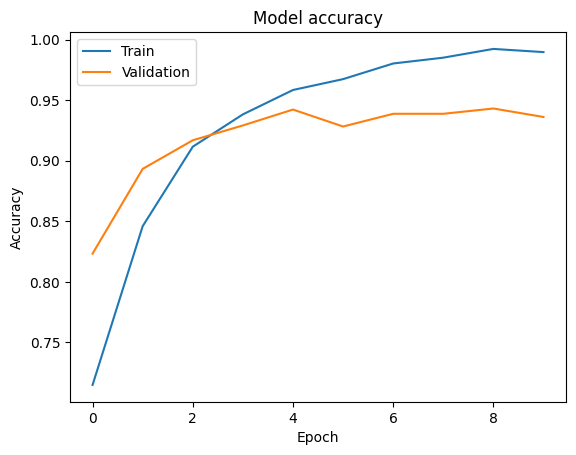

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

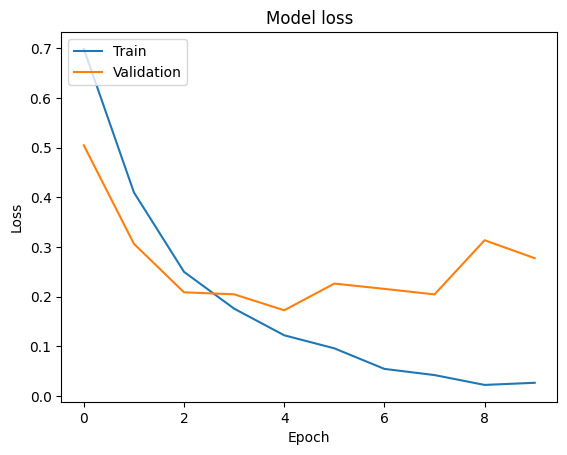

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_encoded)

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)

In [ ]:
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

In [ ]:
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Assuming 4 classes

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history_vgg16 = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_val, y_val_encoded))

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
loss_vgg16, accuracy_vgg16 = model.evaluate(X_test, y_test_encoded)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Calculate confusion matrix
conf_matrix_vgg16 = confusion_matrix(y_test, y_pred_classes_vgg16)

# Calculate precision, recall, and F1-score
precision_vgg16 = precision_score(y_test, y_pred_classes_vgg16, average='weighted')
recall_vgg16 = recall_score(y_test, y_pred_classes_vgg16, average='weighted')
f1_vgg16 = f1_score(y_test, y_pred_classes_vgg16, average='weighted')

print(f"VGG16 Test Loss: {loss_vgg16}")
print(f"VGG16 Test Accuracy: {accuracy_vgg16}")
print(f"VGG16 Precision: {precision_vgg16}")
print(f"VGG16 Recall: {recall_vgg16}")
print(f"VGG16 F1-Score: {f1_vgg16}")
print("VGG16 Confusion Matrix:")
print(conf_matrix_vgg16)


In [ ]:
y_pred_vgg16 = model.predict(X_test)
y_pred_classes_vgg16 = np.argmax(y_pred_vgg16, axis=1)

In [ ]:
# Calculate confusion matrix
conf_matrix_vgg16 = confusion_matrix(y_test, y_pred_classes_vgg16)

In [ ]:
precision_vgg16 = precision_score(y_test, y_pred_classes_vgg16, average='weighted')
recall_vgg16 = recall_score(y_test, y_pred_classes_vgg16, average='weighted')
f1_vgg16 = f1_score(y_test, y_pred_classes_vgg16, average='weighted')


In [ ]:
print(f"VGG16 Test Loss: {loss_vgg16}")
print(f"VGG16 Test Accuracy: {accuracy_vgg16}")
print(f"VGG16 Precision: {precision_vgg16}")
print(f"VGG16 Recall: {recall_vgg16}")
print(f"VGG16 F1-Score: {f1_vgg16}")
print("VGG16 Confusion Matrix:")
print(conf_matrix_vgg16)


In [ ]:
final_val_acc_cnn = history.history['val_accuracy'][-1]
final_val_acc_vgg16 = history_vgg16.history['val_accuracy'][-1]

In [ ]:
print("Final Validation Accuracy - CNN Model:", final_val_acc_cnn)
print("Final Validation Accuracy - VGG16 Model:", final_val_acc_vgg16)

In [ ]:
if final_val_acc_cnn > final_val_acc_vgg16:
    print("CNN Model has a higher validation accuracy.")
else:
    print("VGG16 Model has a higher validation accuracy.")

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='CNN Validation Loss')
plt.plot(history_vgg16.history['val_loss'], label='VGG16 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()

plt.show()

In [ ]:
final_val_acc_cnn_percent = final_val_acc_cnn * 100
final_val_acc_vgg16_percent = final_val_acc_vgg16 * 100

print("Final Validation Accuracy - CNN Model: {:.2f}%".format(final_val_acc_cnn_percent))
print("Final Validation Accuracy - VGG16 Model: {:.2f}%".format(final_val_acc_vgg16_percent))


SVM (Support Vector Machine)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)